# Population vector analysis 

'''Created on Mon 30 Aug 2021'''

In this notebook we will analyze the population vector for different behaviours using the ethogram information that was extracted from DLC for once the mouse in one sessions.

We will abalize the stability of the population vector in a day by day basis for each behavioural state. For visualization we will reduce the dimensionality of the population vector using MultidimensionalScaling or another similar technique that projects the high dimensional vector in a lower dimensionality space preserving distances as much as possible. 

In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math
from sklearn.datasets import load_iris
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn import svm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 56165       ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf=1            ## value of resampling
session_now = 1
BINS = 70
FR_limit = 12
period = int(1 * sf / re_sf)
period_resting = period *10
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!

if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        colapse_behaviour = 1
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        if mouse == 32364:
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
        if mouse == 56165:
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   

    else:
        if session_now == 2:
            task = 'STABLE'
            colapse_behaviour = 2
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        else:
            task = 'RANDOM'
            colapse_behaviour = 0
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]           
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colorn1mes=['k',"r","deepskyblue","g","blue","g","blue"]

    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32366:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            object_fixed = 6
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]

In [3]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_unsup = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_unsupervised/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_parameters = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_parameters/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/center_of_mass/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/pop_vector_stability/'

In [4]:
# define all relevant files names and load them into a list
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
behaviour_list_unsup = []
parameters_list = []
tracking_list = []
total_time = 0
day = 0

print('LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR')
for trial in [1,6,11,16]:

    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_ethogram.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])

    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_parameters.npy'
    ## LOAD PARAMETRS FOR BEHAVIOUR CLASSIFICATION
    parameters = np.load(behaviour_dir_parameters + beh_file_name_1)
    params = []
    for param in range(parameters.shape[0]):
        r1_params = np.reshape(parameters[param,:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
        r2_params = np.reshape(scipy.stats.mode(r1_params,axis=1)[0],reshape_behaviour.shape[0])
        params.append(r2_params)
    resample_params = np.array(params)
        
    ## LOAD TRACKING
    tracking_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75.npy'
    position = np.load(tracking_dir + tracking_file_name_1)
    resample_position, resample_position_stc = stats.resample_matrix(neural_activity=position.T,
                                                                                            re_sf=re_sf)
    ## LOAD TIMELINE
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_'+ f'{trial}'+'_v1.3.1.0_10.pkl'

    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = behaviour.shape[0]
    timeline = timeline_1/re_sf
    time_lenght = 10
    resample_timeline = timeline_1/re_sf
    timeline_list.append(resample_timeline)

    behaviour_list.append(resample_beh1)
    parameters_list.append(resample_params)
    tracking_list.append(resample_position)
    total_time = total_time + behaviour.shape[0]


    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                            '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.0.npy'

     ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = neural_activity1
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                            re_sf=re_sf)

    activity_list.append(resample_neural_activity_mean)

    day = day + 1
        
        

LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR


In [5]:
    ## define targets of behaviour according to protocol (random, overlapping and stable)

    id_target = [0,1,2,3,4,5,6] # 0: unlabeled, 1:resting, 2:Navigation, 3: Obj1, 4:Obj2, 5:Run1, 6:Run2
    
    print('REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS')

    if colapse_behaviour == 0 : # RANDOM
        for day in range(len(behaviour_list)):
            for trial in range(5):
                behaviour_trial = behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])]
                objects = np.unique(behaviour_trial)
                selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
                index0 = np.where(behaviour_trial==objects[selected_object])[0]
                index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-4], behaviour_trial!=objects[selected_object]))
                index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-3], behaviour_trial!=objects[selected_object]))
                behaviour_trial[index0] = 3
                behaviour_trial[index1] = 4
                behaviour_trial[index2] = 4            

                index0 = np.where(behaviour_trial==objects[selected_object]+4)[0]
                index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-2], behaviour_trial!=objects[selected_object]+4))
                index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-1], behaviour_trial!=objects[selected_object]+4))
                behaviour_trial[index0] = 0
                behaviour_trial[index1] = 0
                behaviour_trial[index2] = 0 

                behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])] = behaviour_trial


    if colapse_behaviour == 1 : #OVERLAPPING
        for day in range(len(behaviour_list)):
            behaviour_list[day][np.where(behaviour_list[day] == object_fixed)[0]] = 100
            behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=3, behaviour_list[day]<=6))[0]] = 3
            behaviour_list[day][np.where(behaviour_list[day] == 100)[0]] = 4        
            behaviour_list[day][np.where(behaviour_list[day] == object_fixed +4)[0]] = 200        
            behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=7, behaviour_list[day]<=10))[0]] = 0
            behaviour_list[day][np.where(behaviour_list[day] == 200)[0]] = 0


    if colapse_behaviour == 2: #STABLE
        for day in range(len(behaviour_list)):
            objects = np.unique(behaviour_list[day])
            selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
            index0 = np.where(behaviour_list[day]==objects[selected_object])[0]
            index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-4], behaviour_list[day]!=objects[selected_object]))
            index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-3], behaviour_list[day]!=objects[selected_object]))
            behaviour_list[day][index0] = 3
            behaviour_list[day][index1] = 4
            behaviour_list[day][index2] = 4      

            index0 = np.where(behaviour_list[day]==objects[selected_object]+4)[0]
            index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-2], behaviour_list[day]!=objects[selected_object]+4))
            index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-1], behaviour_list[day]!=objects[selected_object]+4))
            behaviour_list[day][index0] = 0
            behaviour_list[day][index1] = 0
            behaviour_list[day][index2] = 0  

            

REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS


In [6]:
# for each day creates a list that counts and saves times of different events.
# We will consider events here as resting period, navigation periods and object exploration periods.
# Later on will also consider different objects in the exploration periods

events_day_list = []
events_counter_day_list = []
events_time_starts_day = []
for day in range(len(behaviour_list)):
    events_trial_list = []
    events_counter_trial_list = []
    events_time_starts_trial = []
    ### Data selection for a trialwise analysis
    for trial in range(5):
        time0 = int(timeline_list[day][trial*2])
        time1 = int(timeline_list[day][trial*2+1])

        behaviour_trial = behaviour_list[day][time0:time1]
        events_list = []
        events_counter_list = []
        events_time_starts = []
        start_counter = 100
        counter = 0
        for i in range(behaviour_trial.shape[0]):
            if behaviour_trial[i] != start_counter:
                events_list.append(start_counter)
                events_counter_list.append(counter)
                events_time_starts.append(i)
                start_counter = behaviour_list[day][i]
                counter = 1
            else:
                counter = counter + 1
        events_trial_list.append(events_list)
        events_counter_trial_list.append(events_counter_list)
        events_time_starts_trial.append(events_time_starts)
        
    events_day_list.append(events_trial_list)
    events_counter_day_list.append(events_counter_trial_list)
    events_time_starts_day.append(events_time_starts_trial)

In [51]:
# separte events belonging to each of the behavioural conditions

behavioural_events_days_list = []
conditions = labels

for day in range(len(behaviour_list)):
    behavioural_events_trial_list = []
    for trial in range(5):
        events = np.array(events_day_list[day][trial])
        events_counter = np.array(events_counter_day_list[day][trial])
        events_time = np.array(events_time_starts_day[day][trial])

        object_list = []
        for target in [3,4]:
            period1 = 10
            if target == 0:
                period1 = period_resting
            object_data = []
            position_events = np.where(events == target)[0]
            events_duration = events_counter[position_events]   # convert to seconds
            time = events_time[position_events]
            i = 0
            for event in events_duration:
                if event:
                    object_data.append(activity_list[day][:,time[i]:time[i]+period1])
                i = i + 1
            object_list.append(object_data)
        behavioural_events_trial_list.append(object_list)
    behavioural_events_days_list.append(behavioural_events_trial_list)

In [52]:
population_vector_day = []
for day in range(len(behaviour_list)):
    population_vector_trial = []
    for trial in range(5):
        mean_over_trials_list = []
        for i in range(len(behavioural_events_days_list[day][trial])):
            mean_over_trials= np.mean(behavioural_events_days_list[day][trial][i], axis= 0)
            if mean_over_trials.shape:
                mean_over_trials_list.append(np.mean(mean_over_trials,axis=1))#/np.max(np.mean(mean_over_trials,axis=1)))
        population_vector_trial.append(mean_over_trials_list)
    population_vector_day.append(population_vector_trial)

(2, 195)
(2, 3)
(2, 195)
(2, 3)
(2, 195)
(2, 3)
(2, 195)
(2, 3)
(2, 195)
(2, 3)
(2, 448)
(2, 3)
(2, 448)
(2, 3)
(2, 448)
(2, 3)
(2, 448)
(2, 3)
(2, 448)
(2, 3)
(2, 322)
(2, 3)
(2, 322)
(2, 3)
(2, 322)
(2, 3)
(2, 322)
(2, 3)
(2, 322)
(2, 3)
(2, 397)
(2, 3)
(2, 397)
(2, 3)
(2, 397)
(2, 3)
(2, 397)
(2, 3)
(2, 397)
(2, 3)


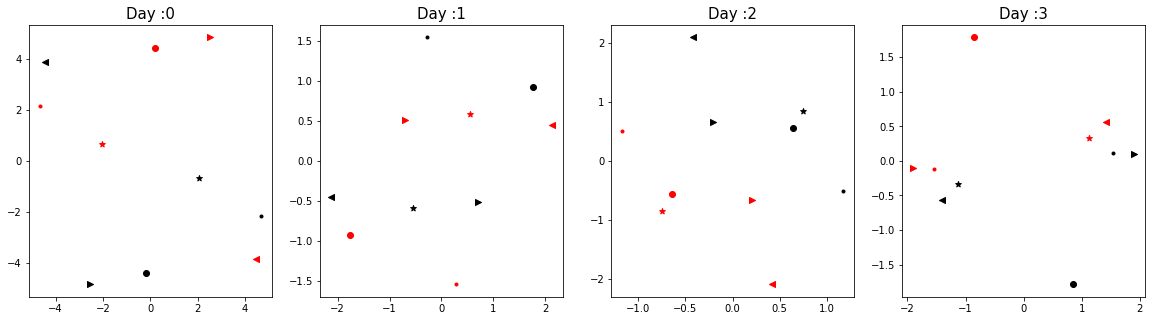

In [58]:
from sklearn.manifold import MDS

embedding = MDS(n_components=3)
fig = plt.figure(figsize=(20, 5))
grid = plt.GridSpec(1,4)
colornames=["r","k","g","blue","orange"]
markertype = ['*','>','<','o','.']

for day in range(4):
    ax1 = fig.add_subplot(grid[0,day])#,projection='3d')
    for trial in range(5):
        X = np.array(population_vector_day[day][trial])
        print(X.shape)
        #if X.shape[0] > 3 :
        X_transformed = embedding.fit_transform(X)
        print(X_transformed.shape)
        for i in range(X_transformed.shape[0]):
            ax1.scatter(X_transformed[i,0],X_transformed[i,1],color = colornames[i],marker = markertype[trial])
            #print(X_transformed.shape)
    ax1.set_title('Day :' + f'{day}', fontsize = 15)
    #ax1.legend(['Rest0','Rest1','Nav','Obj1','Onj2'])
    
    #ax1.legend(['Trial1-obj1','Trial1-Obj2','Trial2-obj1','Trial2-Obj2','Trial3-obj1','Trial3-Obj2','Trial4-obj1','Trial4-Obj2','Trial5-obj1','Trial5-Obj2'])

# PC population analysis with MDS

In [11]:
pca = PCA()
activity_list_pca = []
variance_list = []
variance_ratio_list = []

cca_components = min(13,activity_list[day].shape[0])
cca = CCA(n_components=cca_components)
activity_list_cca = []

for day in range(len(behaviour_list)):
    ### run pca on the entire dataset
    pca.fit(activity_list[day].T)
    transformed_activity = pca.fit(activity_list[day].T).transform(activity_list[day].T)
    activity_list_pca.append(transformed_activity.T)
    variance_list.append(pca.explained_variance_/(1+np.sqrt(activity_list[day].shape[0]/activity_list[day].shape[1]))**2)
    normalized_variance = pca.explained_variance_/(1+np.sqrt(activity_list[day].shape[0]/activity_list[day].shape[1]))**2
    variance_ratio_list.append(np.cumsum(normalized_variance/sum(normalized_variance)))
    activity_list_cca.append(cca.fit(activity_list[day].T, parameters_list[day].T).transform(activity_list[day].T))
    


In [12]:
# for each day creates a list that counts and saves times of different events.
# We will consider events here as resting period, navigation periods and object exploration periods.
# Later on will also consider different objects in the exploration periods

events_day_list = []
events_counter_day_list = []
events_time_starts_day = []
for day in range(len(behaviour_list)):
    events_trial_list = []
    events_counter_trial_list = []
    events_time_starts_trial = []
    ### Data selection for a trialwise analysis
    for trial in range(5):
        time0 = int(timeline_list[day][trial*2])
        time1 = int(timeline_list[day][trial*2+1])

        behaviour_trial = behaviour_list[day][time0:time1]
        events_list = []
        events_counter_list = []
        events_time_starts = []
        start_counter = 100
        counter = 0
        for i in range(behaviour_trial.shape[0]):
            if behaviour_trial[i] != start_counter:
                events_list.append(start_counter)
                events_counter_list.append(counter)
                events_time_starts.append(i)
                start_counter = behaviour_list[day][i]
                counter = 1
            else:
                counter = counter + 1
        events_trial_list.append(events_list)
        events_counter_trial_list.append(events_counter_list)
        events_time_starts_trial.append(events_time_starts)
        
    events_day_list.append(events_trial_list)
    events_counter_day_list.append(events_counter_trial_list)
    events_time_starts_day.append(events_time_starts_trial)

In [13]:
# separte events belonging to each of the behavioural conditions

behavioural_events_days_list = []
behavioural_pca_events_days_list = []
behavioural_cca_events_days_list = []

conditions = labels

for day in range(len(behaviour_list)):
    behavioural_events_trial_list = []
    behavioural_pca_events_trial_list = []
    behavioural_cca_events_trial_list = []

    for trial in range(5):
        events = np.array(events_day_list[day][trial])
        events_counter = np.array(events_counter_day_list[day][trial])
        events_time = np.array(events_time_starts_day[day][trial])

        object_list = []
        object_pca_list = []
        object_cca_list = []
        for target in [3,4]:
            object_data = []
            object_pca_data = []
            object_cca_data = []
            position_events = np.where(events == target)[0]
            events_duration = events_counter[position_events]   # convert to seconds
            time = events_time[position_events]
            i = 0
            for event in events_duration:
                if event > 0:
                    object_data.append(activity_list[day][:,time[i]:time[i]+period1])
                    object_pca_data.append(activity_list_pca[day][:,time[i]:time[i]+period1])
                    object_cca_data.append(activity_list_cca[day][:,time[i]:time[i]+period1])
                i = i + 1
            object_list.append(object_data)
            object_pca_list.append(object_data)
            object_cca_list.append(object_data)
        behavioural_events_trial_list.append(object_list)
        behavioural_pca_events_trial_list.append(object_list)
        behavioural_cca_events_trial_list.append(object_list)
    behavioural_events_days_list.append(behavioural_events_trial_list)
    behavioural_pca_events_days_list.append(behavioural_events_trial_list)
    behavioural_cca_events_days_list.append(behavioural_events_trial_list)

In [14]:
population_vector_day = []
for day in range(len(behaviour_list)):
    population_vector_trial = []
    for trial in range(5):
        mean_over_trials_list = []
        for i in range(len(behavioural_events_days_list[day][trial])):
            mean_over_trials= np.mean(behavioural_pca_events_days_list[day][trial][i], axis= 0)
            #print(len(behavioural_pca_events_days_list[day][trial][i]))
            if mean_over_trials.shape:
                mean_over_trials_list.append(np.mean(mean_over_trials[0:100],axis=1))#/np.max(np.mean(mean_over_trials[0:100],axis=1)))
        population_vector_trial.append(mean_over_trials_list)
    population_vector_day.append(population_vector_trial)

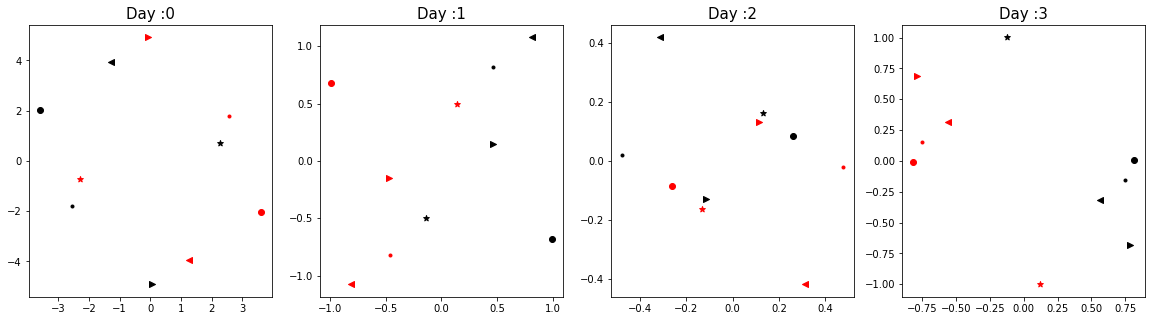

In [15]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2)
fig = plt.figure(figsize=(20, 5))
grid = plt.GridSpec(1,4)
colornames=["r","k","g","blue"]
markertype = ['*','>','<','o','.']

for day in range(4):
    ax1 = fig.add_subplot(grid[0,day])#,projection='3d')
    for trial in range(5):
        X = np.array(population_vector_day[day][trial])
        #print(X.shape)
        #if X.shape[0] > 3 :
        X_transformed = embedding.fit_transform(X)
        #print(X_transformed.shape)
        for i in range(X_transformed.shape[0]):
            ax1.scatter(X_transformed[i,0],X_transformed[i,1],color = colornames[i],marker = markertype[trial])
            #print(X_transformed.shape)
    ax1.set_title('Day :' + f'{day}', fontsize = 15)


In [16]:
population_vector_day = []
for day in range(len(behaviour_list)):
    population_vector_trial = []
    for trial in range(5):
        mean_over_trials_list = []
        for i in range(len(behavioural_events_days_list[day][trial])):
            mean_over_trials= np.mean(behavioural_cca_events_days_list[day][trial][i], axis= 0)
            #print(len(behavioural_pca_events_days_list[day][trial][i]))
            if mean_over_trials.shape:
                #print(mean_over_trials.shape)
                mean_over_trials_list.append(np.mean(mean_over_trials[0:13],axis=1))#/np.max(np.mean(mean_over_trials[0:100],axis=1)))
        population_vector_trial.append(mean_over_trials_list)
    population_vector_day.append(population_vector_trial)

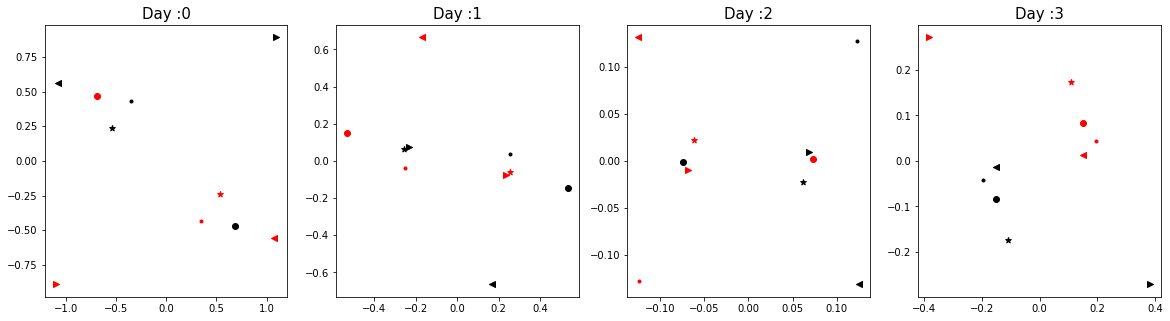

In [17]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2)
fig = plt.figure(figsize=(20, 5))
grid = plt.GridSpec(1,4)
colornames=["r","k","g","blue"]
markertype = ['*','>','<','o','.']

for day in range(4):
    ax1 = fig.add_subplot(grid[0,day])#,projection='3d')
    for trial in range(5):
        X = np.array(population_vector_day[day][trial])
        #print(X.shape)
        #if X.shape[0] > 3 :
        X_transformed = embedding.fit_transform(X)
        #print(X_transformed.shape)
        for i in range(X_transformed.shape[0]):
            ax1.scatter(X_transformed[i,0],X_transformed[i,1],color = colornames[i],marker = markertype[trial])
            #print(X_transformed.shape)
    ax1.set_title('Day :' + f'{day}', fontsize = 15)